In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates


In [28]:
import torch
print(torch.version.cuda)
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import dataset as ds
import utils
from torch.utils.data import DataLoader
import torch
import datetime
import transformer_timeseries as tst
import numpy as np

# Hyperparams
test_size = 0.1
batch_size = 128
target_col_name = "Price"
timestamp_col = "Date"


## Params
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 92 # length of input given to decoder
enc_seq_len = 153 # length of input given to encoder
output_sequence_length = 1 # target sequence length. If hourly data and length = 48, you predict 2 days ahead
window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = True

11.3
cuda:0


In [29]:
# Define input variables 
exogenous_vars = [] # should contain strings. Each string must correspond to a column name
input_variables = [target_col_name] + exogenous_vars
target_idx = 0 # index position of target in batched trg_y

input_size = len(input_variables)

# Read data
data = pd.read_csv(
    'USD_EUR Historical Data.csv', 
    parse_dates=[timestamp_col], 
    index_col=[timestamp_col], 
    infer_datetime_format=True,
    low_memory=False
)

# Remove test data from dataset
training_data = data[:-(round(len(data)*test_size))]

# Make list of (start_idx, end_idx) pairs that are used to slice the time series sequence into chunkc. 
# Should be training data indices only
training_indices = utils.get_indices_entire_sequence(
    data=training_data, 
    window_size=window_size, 
    step_size=step_size)

# Making instance of custom dataset class
training_data = ds.TransformerDataset(
    data=torch.tensor(training_data[input_variables].values.tolist()).float().to(device),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )

# Making dataloader
training_data = DataLoader(training_data, batch_size)

len(training_data)

i, batch = next(enumerate(training_data))

src, trg, trg_y = batch

src.shape
trg.shape
trg_y.shape


model = tst.TimeSeriesTransformer(
    input_size=len(input_variables),
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
    )

model = model.to(device)

# Make src mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, enc_seq_len]
src_mask = utils.generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = utils.generate_square_subsequent_mask( 
    dim1=output_sequence_length,
    dim2=output_sequence_length
    )

output = model(
    src=src.to(device),
    tgt=trg.to(device),
    src_mask=src_mask.to(device),
    tgt_mask=tgt_mask.to(device)
    )


From get_src_trg: data size = torch.Size([4500, 1])


In [30]:
data = data[['Price']]

In [37]:
len(data)

5000

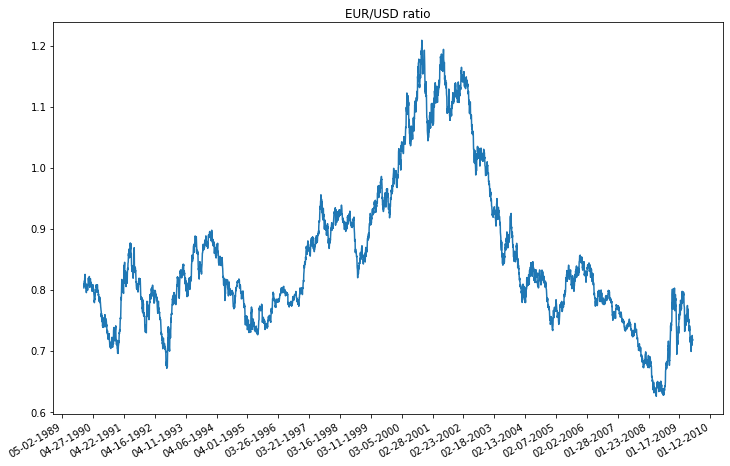

In [38]:
plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=360))
plt.plot(data)
plt.gcf().autofmt_xdate()
plt.title('EUR/USD ratio')
plt.show()

In [5]:
from tqdm import tqdm
losses = []
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for t in tqdm(range(200)):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(
        src=src.to(device),
        tgt=trg.to(device),
        src_mask=src_mask.to(device),
        tgt_mask=tgt_mask.to(device)
    )
    #print(y_pred)
    #print(trg_y)

    

    # Compute and print loss
    loss = criterion(y_pred.reshape(trg_y.shape), trg_y)
    losses.append(loss)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

0 24.83473777770996


  0%|          | 1/200 [00:00<02:02,  1.63it/s]

1 2454.42578125


  1%|          | 2/200 [00:01<01:49,  1.81it/s]

2 382.9703369140625


  2%|▏         | 3/200 [00:01<01:46,  1.84it/s]

3 125.18382263183594


  2%|▏         | 4/200 [00:02<01:44,  1.87it/s]

4 518.373291015625


  2%|▎         | 5/200 [00:02<01:44,  1.86it/s]

5 413.03411865234375


  3%|▎         | 6/200 [00:03<01:43,  1.87it/s]

6 163.30355834960938


  4%|▎         | 7/200 [00:03<01:42,  1.88it/s]

7 19.74193572998047


  4%|▍         | 8/200 [00:04<01:41,  1.88it/s]

8 15.164766311645508


  4%|▍         | 9/200 [00:04<01:40,  1.89it/s]

9 76.564208984375


  5%|▌         | 10/200 [00:05<01:40,  1.90it/s]

10 119.71388244628906


  6%|▌         | 11/200 [00:05<01:39,  1.89it/s]

11 122.95085144042969


  6%|▌         | 12/200 [00:06<01:39,  1.90it/s]

12 93.89878845214844


  6%|▋         | 13/200 [00:06<01:38,  1.90it/s]

13 46.01704406738281


  7%|▋         | 14/200 [00:07<01:37,  1.90it/s]

14 13.933483123779297


  8%|▊         | 15/200 [00:07<01:37,  1.90it/s]

15 2.9803271293640137


  8%|▊         | 16/200 [00:08<01:36,  1.90it/s]

16 13.308709144592285


  8%|▊         | 17/200 [00:09<01:36,  1.90it/s]

17 32.57113265991211


  9%|▉         | 18/200 [00:09<01:35,  1.90it/s]

18 46.93778610229492


 10%|▉         | 19/200 [00:10<01:35,  1.90it/s]

19 48.89036560058594


 10%|█         | 20/200 [00:10<01:34,  1.90it/s]

20 44.79444885253906


 10%|█         | 21/200 [00:11<01:34,  1.90it/s]

21 26.119308471679688


 11%|█         | 22/200 [00:11<01:33,  1.89it/s]

22 12.324712753295898


 12%|█▏        | 23/200 [00:12<01:33,  1.90it/s]

23 3.6193366050720215


 12%|█▏        | 24/200 [00:12<01:32,  1.90it/s]

24 2.5453054904937744


 12%|█▎        | 25/200 [00:13<01:32,  1.90it/s]

25 7.616111755371094


 13%|█▎        | 26/200 [00:13<01:31,  1.89it/s]

26 12.244365692138672


 14%|█▎        | 27/200 [00:14<01:31,  1.89it/s]

27 18.10975456237793


 14%|█▍        | 28/200 [00:14<01:30,  1.89it/s]

28 19.6518611907959


 14%|█▍        | 29/200 [00:15<01:30,  1.89it/s]

29 17.515594482421875


 15%|█▌        | 30/200 [00:15<01:29,  1.89it/s]

30 11.503410339355469


 16%|█▌        | 31/200 [00:16<01:29,  1.89it/s]

31 8.310271263122559


 16%|█▌        | 32/200 [00:16<01:28,  1.89it/s]

32 4.103474140167236


 16%|█▋        | 33/200 [00:17<01:28,  1.89it/s]

33 2.441343069076538


 17%|█▋        | 34/200 [00:18<01:27,  1.89it/s]

34 4.588387489318848


 18%|█▊        | 35/200 [00:18<01:27,  1.89it/s]

35 6.121308326721191


 18%|█▊        | 36/200 [00:19<01:26,  1.89it/s]

36 8.057014465332031


 18%|█▊        | 37/200 [00:19<01:26,  1.88it/s]

37 9.190536499023438


 19%|█▉        | 38/200 [00:20<01:26,  1.88it/s]

38 9.867902755737305


 20%|█▉        | 39/200 [00:20<01:26,  1.87it/s]

39 8.415349960327148


 20%|██        | 40/200 [00:21<01:25,  1.87it/s]

40 4.77435302734375


 20%|██        | 41/200 [00:21<01:24,  1.87it/s]

41 3.4890284538269043


 21%|██        | 42/200 [00:22<01:24,  1.88it/s]

42 2.059494733810425


 22%|██▏       | 43/200 [00:22<01:23,  1.88it/s]

43 2.82331919670105


 22%|██▏       | 44/200 [00:23<01:23,  1.87it/s]

44 4.108612060546875


 22%|██▎       | 45/200 [00:23<01:22,  1.87it/s]

45 4.829302787780762


 23%|██▎       | 46/200 [00:24<01:22,  1.87it/s]

46 4.706462383270264


 24%|██▎       | 47/200 [00:24<01:21,  1.87it/s]

47 4.324828147888184


 24%|██▍       | 48/200 [00:25<01:21,  1.87it/s]

48 4.780256271362305


 24%|██▍       | 49/200 [00:26<01:20,  1.87it/s]

49 3.1090502738952637


 25%|██▌       | 50/200 [00:26<01:20,  1.87it/s]

50 2.2884716987609863


 26%|██▌       | 51/200 [00:27<01:19,  1.87it/s]

51 2.3076047897338867


 26%|██▌       | 52/200 [00:27<01:19,  1.87it/s]

52 2.1121983528137207


 26%|██▋       | 53/200 [00:28<01:18,  1.87it/s]

53 2.60689640045166


 27%|██▋       | 54/200 [00:28<01:18,  1.87it/s]

54 2.733102798461914


 28%|██▊       | 55/200 [00:29<01:17,  1.87it/s]

55 4.215418815612793


 28%|██▊       | 56/200 [00:29<01:17,  1.87it/s]

56 3.110797882080078


 28%|██▊       | 57/200 [00:30<01:16,  1.87it/s]

57 3.365657329559326


 29%|██▉       | 58/200 [00:30<01:16,  1.86it/s]

58 2.7329654693603516


 30%|██▉       | 59/200 [00:31<01:15,  1.86it/s]

59 2.3800930976867676


 30%|███       | 60/200 [00:31<01:15,  1.86it/s]

60 2.052917003631592


 30%|███       | 61/200 [00:32<01:14,  1.86it/s]

61 2.548401355743408


 31%|███       | 62/200 [00:33<01:14,  1.86it/s]

62 2.8680238723754883


 32%|███▏      | 63/200 [00:33<01:13,  1.86it/s]

63 3.937189817428589


 32%|███▏      | 64/200 [00:34<01:13,  1.86it/s]

64 2.506094217300415


 32%|███▎      | 65/200 [00:34<01:12,  1.86it/s]

65 2.086686611175537


 33%|███▎      | 66/200 [00:35<01:12,  1.85it/s]

66 2.1379473209381104


 34%|███▎      | 67/200 [00:35<01:11,  1.85it/s]

67 2.1412203311920166


 34%|███▍      | 68/200 [00:36<01:11,  1.86it/s]

68 2.1231276988983154


 34%|███▍      | 69/200 [00:36<01:10,  1.86it/s]

69 2.5497541427612305


 35%|███▌      | 70/200 [00:37<01:10,  1.86it/s]

70 2.458099842071533


 36%|███▌      | 71/200 [00:37<01:09,  1.85it/s]

71 2.1654770374298096


 36%|███▌      | 72/200 [00:38<01:09,  1.85it/s]

72 2.3636558055877686


 36%|███▋      | 73/200 [00:38<01:08,  1.85it/s]

73 2.258523941040039


 37%|███▋      | 74/200 [00:39<01:08,  1.85it/s]

74 1.8416895866394043


 38%|███▊      | 75/200 [00:40<01:07,  1.85it/s]

75 1.9868321418762207


 38%|███▊      | 76/200 [00:40<01:07,  1.85it/s]

76 1.9487414360046387


 38%|███▊      | 77/200 [00:41<01:06,  1.85it/s]

77 2.3290815353393555


 39%|███▉      | 78/200 [00:41<01:06,  1.84it/s]

78 2.1345632076263428


 40%|███▉      | 79/200 [00:42<01:05,  1.84it/s]

79 2.2024123668670654


 40%|████      | 80/200 [00:42<01:05,  1.84it/s]

80 2.171938419342041


 40%|████      | 81/200 [00:43<01:04,  1.84it/s]

81 2.118760585784912


 41%|████      | 82/200 [00:43<01:04,  1.84it/s]

82 2.1413826942443848


 42%|████▏     | 83/200 [00:44<01:03,  1.84it/s]

83 1.964968204498291


 42%|████▏     | 84/200 [00:44<01:03,  1.84it/s]

84 2.300168514251709


 42%|████▎     | 85/200 [00:45<01:02,  1.83it/s]

85 1.7350282669067383


 43%|████▎     | 86/200 [00:46<01:02,  1.83it/s]

86 2.170811653137207


 44%|████▎     | 87/200 [00:46<01:01,  1.83it/s]

87 1.5617443323135376


 44%|████▍     | 88/200 [00:47<01:01,  1.83it/s]

88 1.9490060806274414


 44%|████▍     | 89/200 [00:47<01:00,  1.83it/s]

89 2.466142177581787


 45%|████▌     | 90/200 [00:48<01:00,  1.83it/s]

90 2.738651990890503


 46%|████▌     | 91/200 [00:48<00:59,  1.83it/s]

91 2.139535427093506


 46%|████▌     | 92/200 [00:49<00:59,  1.83it/s]

92 1.798427700996399


 46%|████▋     | 93/200 [00:49<00:58,  1.83it/s]

93 2.363011121749878


 47%|████▋     | 94/200 [00:50<00:58,  1.83it/s]

94 2.2107560634613037


 48%|████▊     | 95/200 [00:50<00:57,  1.82it/s]

95 2.507352828979492


 48%|████▊     | 96/200 [00:51<00:57,  1.82it/s]

96 1.779242753982544


 48%|████▊     | 97/200 [00:52<00:56,  1.82it/s]

97 1.9394899606704712


 49%|████▉     | 98/200 [00:52<00:56,  1.82it/s]

98 1.7332193851470947


 50%|████▉     | 99/200 [00:53<00:55,  1.82it/s]

99 1.6828638315200806


 50%|█████     | 100/200 [00:53<00:54,  1.82it/s]

100 2.3741302490234375


 50%|█████     | 101/200 [00:54<00:54,  1.83it/s]

101 1.8260793685913086


 51%|█████     | 102/200 [00:54<00:53,  1.82it/s]

102 1.8161165714263916


 52%|█████▏    | 103/200 [00:55<00:53,  1.83it/s]

103 2.269148111343384


 52%|█████▏    | 104/200 [00:55<00:52,  1.83it/s]

104 1.8098640441894531


 52%|█████▎    | 105/200 [00:56<00:52,  1.83it/s]

105 1.7172523736953735


 53%|█████▎    | 106/200 [00:56<00:51,  1.82it/s]

106 1.7489055395126343


 54%|█████▎    | 107/200 [00:57<00:50,  1.82it/s]

107 1.9340620040893555


 54%|█████▍    | 108/200 [00:58<00:50,  1.82it/s]

108 1.6892037391662598


 55%|█████▍    | 109/200 [00:58<00:49,  1.82it/s]

109 1.8233836889266968


 55%|█████▌    | 110/200 [00:59<00:49,  1.82it/s]

110 2.0470871925354004


 56%|█████▌    | 111/200 [00:59<00:49,  1.82it/s]

111 1.8516240119934082


 56%|█████▌    | 112/200 [01:00<00:48,  1.82it/s]

112 1.4678065776824951


 56%|█████▋    | 113/200 [01:00<00:47,  1.82it/s]

113 1.684351921081543


 57%|█████▋    | 114/200 [01:01<00:47,  1.81it/s]

114 2.678913116455078


 57%|█████▊    | 115/200 [01:01<00:46,  1.81it/s]

115 1.8136382102966309


 58%|█████▊    | 116/200 [01:02<00:46,  1.81it/s]

116 2.0287933349609375


 58%|█████▊    | 117/200 [01:03<00:45,  1.82it/s]

117 1.9797453880310059


 59%|█████▉    | 118/200 [01:03<00:45,  1.81it/s]

118 2.437018632888794


 60%|█████▉    | 119/200 [01:04<00:44,  1.81it/s]

119 1.663086175918579


 60%|██████    | 120/200 [01:04<00:44,  1.81it/s]

120 1.8825819492340088


 60%|██████    | 121/200 [01:05<00:43,  1.81it/s]

121 1.8380177021026611


 61%|██████    | 122/200 [01:05<00:43,  1.80it/s]

122 2.3154547214508057


 62%|██████▏   | 123/200 [01:06<00:42,  1.81it/s]

123 1.8242051601409912


 62%|██████▏   | 124/200 [01:06<00:42,  1.80it/s]

124 1.8387693166732788


 62%|██████▎   | 125/200 [01:07<00:41,  1.80it/s]

125 1.312799096107483


 63%|██████▎   | 126/200 [01:08<00:41,  1.80it/s]

126 1.8485692739486694


 64%|██████▎   | 127/200 [01:08<00:40,  1.80it/s]

127 1.9594435691833496


 64%|██████▍   | 128/200 [01:09<00:40,  1.80it/s]

128 2.139289617538452


 64%|██████▍   | 129/200 [01:09<00:39,  1.80it/s]

129 2.063214063644409


 65%|██████▌   | 130/200 [01:10<00:38,  1.80it/s]

130 1.2930978536605835


 66%|██████▌   | 131/200 [01:10<00:38,  1.80it/s]

131 1.5080921649932861


 66%|██████▌   | 132/200 [01:11<00:37,  1.79it/s]

132 1.6158792972564697


 66%|██████▋   | 133/200 [01:11<00:37,  1.79it/s]

133 1.7298243045806885


 67%|██████▋   | 134/200 [01:12<00:36,  1.79it/s]

134 1.2928376197814941


 68%|██████▊   | 135/200 [01:13<00:36,  1.79it/s]

135 1.459009051322937


 68%|██████▊   | 136/200 [01:13<00:35,  1.79it/s]

136 1.7888460159301758


 68%|██████▊   | 137/200 [01:14<00:35,  1.79it/s]

137 1.8683422803878784


 69%|██████▉   | 138/200 [01:14<00:34,  1.79it/s]

138 1.997429609298706


 70%|██████▉   | 139/200 [01:15<00:34,  1.78it/s]

139 1.2483129501342773


 70%|███████   | 140/200 [01:15<00:33,  1.79it/s]

140 1.8692524433135986


 70%|███████   | 141/200 [01:16<00:33,  1.78it/s]

141 1.7161192893981934


 71%|███████   | 142/200 [01:16<00:32,  1.78it/s]

142 1.3118107318878174


 72%|███████▏  | 143/200 [01:17<00:31,  1.78it/s]

143 1.591217279434204


 72%|███████▏  | 144/200 [01:18<00:31,  1.78it/s]

144 1.3854596614837646


 72%|███████▎  | 145/200 [01:18<00:30,  1.78it/s]

145 1.8428897857666016


 73%|███████▎  | 146/200 [01:19<00:30,  1.78it/s]

146 1.4333813190460205


 74%|███████▎  | 147/200 [01:19<00:29,  1.78it/s]

147 1.6895805597305298


 74%|███████▍  | 148/200 [01:20<00:29,  1.78it/s]

148 1.832751750946045


 74%|███████▍  | 149/200 [01:20<00:28,  1.77it/s]

149 1.9193098545074463


 75%|███████▌  | 150/200 [01:21<00:28,  1.77it/s]

150 1.8023011684417725


 76%|███████▌  | 151/200 [01:22<00:27,  1.77it/s]

151 1.981101155281067


 76%|███████▌  | 152/200 [01:22<00:27,  1.77it/s]

152 1.676572561264038


 76%|███████▋  | 153/200 [01:23<00:26,  1.77it/s]

153 1.7387144565582275


 77%|███████▋  | 154/200 [01:23<00:26,  1.77it/s]

154 1.9510772228240967


 78%|███████▊  | 155/200 [01:24<00:25,  1.77it/s]

155 1.5301276445388794


 78%|███████▊  | 156/200 [01:24<00:24,  1.77it/s]

156 1.3999112844467163


 78%|███████▊  | 157/200 [01:25<00:24,  1.76it/s]

157 2.0991151332855225


 79%|███████▉  | 158/200 [01:26<00:23,  1.76it/s]

158 1.5425361394882202


 80%|███████▉  | 159/200 [01:26<00:23,  1.76it/s]

159 1.8432575464248657


 80%|████████  | 160/200 [01:27<00:22,  1.76it/s]

160 1.694411039352417


 80%|████████  | 161/200 [01:27<00:22,  1.76it/s]

161 1.4921414852142334


 81%|████████  | 162/200 [01:28<00:21,  1.76it/s]

162 1.4303112030029297


 82%|████████▏ | 163/200 [01:28<00:21,  1.76it/s]

163 1.2660067081451416


 82%|████████▏ | 164/200 [01:29<00:20,  1.76it/s]

164 1.3677170276641846


 82%|████████▎ | 165/200 [01:30<00:19,  1.76it/s]

165 1.574941635131836


 83%|████████▎ | 166/200 [01:30<00:19,  1.76it/s]

166 1.7311158180236816


 84%|████████▎ | 167/200 [01:31<00:18,  1.76it/s]

167 1.5305651426315308


 84%|████████▍ | 168/200 [01:31<00:18,  1.76it/s]

168 1.4733078479766846


 84%|████████▍ | 169/200 [01:32<00:17,  1.76it/s]

169 1.9940392971038818


 85%|████████▌ | 170/200 [01:32<00:17,  1.76it/s]

170 1.04218327999115


 86%|████████▌ | 171/200 [01:33<00:16,  1.76it/s]

171 1.399305820465088


 86%|████████▌ | 172/200 [01:33<00:15,  1.76it/s]

172 1.1908888816833496


 86%|████████▋ | 173/200 [01:34<00:15,  1.76it/s]

173 1.6711565256118774


 87%|████████▋ | 174/200 [01:35<00:14,  1.75it/s]

174 1.3376976251602173


 88%|████████▊ | 175/200 [01:35<00:14,  1.75it/s]

175 1.7341670989990234


 88%|████████▊ | 176/200 [01:36<00:13,  1.75it/s]

176 1.5479779243469238


 88%|████████▊ | 177/200 [01:36<00:13,  1.75it/s]

177 1.3334189653396606


 89%|████████▉ | 178/200 [01:37<00:12,  1.75it/s]

178 1.3778479099273682


 90%|████████▉ | 179/200 [01:37<00:11,  1.75it/s]

179 1.4058685302734375


 90%|█████████ | 180/200 [01:38<00:11,  1.75it/s]

180 1.4882304668426514


 90%|█████████ | 181/200 [01:39<00:10,  1.75it/s]

181 1.7829691171646118


 91%|█████████ | 182/200 [01:39<00:10,  1.75it/s]

182 1.6196582317352295


 92%|█████████▏| 183/200 [01:40<00:09,  1.74it/s]

183 1.472785234451294


 92%|█████████▏| 184/200 [01:40<00:09,  1.74it/s]

184 1.9377694129943848


 92%|█████████▎| 185/200 [01:41<00:08,  1.74it/s]

185 1.5321736335754395


 93%|█████████▎| 186/200 [01:42<00:08,  1.74it/s]

186 1.1215486526489258


 94%|█████████▎| 187/200 [01:42<00:07,  1.74it/s]

187 1.2402713298797607


 94%|█████████▍| 188/200 [01:43<00:06,  1.74it/s]

188 1.4044010639190674


 94%|█████████▍| 189/200 [01:43<00:06,  1.74it/s]

189 1.1716054677963257


 95%|█████████▌| 190/200 [01:44<00:05,  1.73it/s]

190 1.2727915048599243


 96%|█████████▌| 191/200 [01:44<00:05,  1.74it/s]

191 1.5298341512680054


 96%|█████████▌| 192/200 [01:45<00:04,  1.73it/s]

192 1.4300649166107178


 96%|█████████▋| 193/200 [01:46<00:04,  1.73it/s]

193 1.046830415725708


 97%|█████████▋| 194/200 [01:46<00:03,  1.73it/s]

194 1.5381414890289307


 98%|█████████▊| 195/200 [01:47<00:02,  1.73it/s]

195 1.2266812324523926


 98%|█████████▊| 196/200 [01:47<00:02,  1.73it/s]

196 1.1840717792510986


 98%|█████████▊| 197/200 [01:48<00:01,  1.73it/s]

197 1.6220338344573975


 99%|█████████▉| 198/200 [01:48<00:01,  1.73it/s]

198 1.2961955070495605


100%|█████████▉| 199/200 [01:49<00:00,  1.73it/s]

199 1.3017995357513428


100%|██████████| 200/200 [01:50<00:00,  1.82it/s]


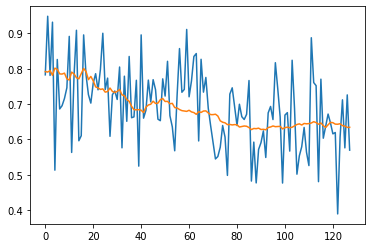

In [6]:
plt.plot(y_pred.reshape(trg_y.shape).cpu().detach().numpy())
plt.plot(trg_y.cpu().detach().numpy())

In [ ]:

y_pred.reshape(trg_y.shape), trg_y

In [7]:
test_data = data[-(round(len(data)*test_size)):]



test_indices = utils.get_indices_entire_sequence(
    data=test_data, 
    window_size=window_size, 
    step_size=step_size)

# Making instance of custom dataset class
test_data = ds.TransformerDataset(
    data=torch.tensor(test_data[input_variables].values.tolist()).float().to(device),
    indices=test_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length
    )



From get_src_trg: data size = torch.Size([500, 1])


In [8]:
test_data = DataLoader(test_data, batch_size)

len(test_data)

i, batch_test = next(enumerate(test_data))

src_test, trg_test, trg_y_test = batch_test

In [9]:
src_mask_test = utils.generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask_test = utils.generate_square_subsequent_mask( 
    dim1=output_sequence_length,
    dim2=output_sequence_length
    )

In [ ]:
print(src_test.shape)
print(trg_test.shape)
print(trg_y_test.shape)

torch.Size([128, 153, 1])
torch.Size([128, 1, 1])
torch.Size([128, 1])


In [10]:
y_pred_test = model(
    src=src_test.to(device),
    tgt=trg_test.to(device),
    src_mask=src_mask_test.to(device),
    tgt_mask=tgt_mask_test.to(device)
)

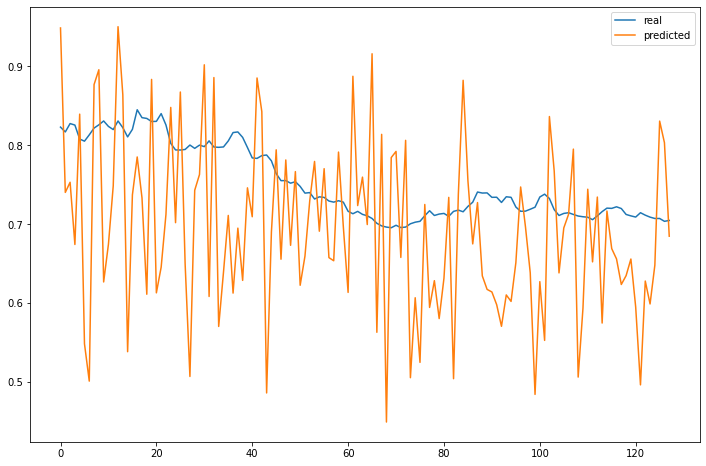

In [39]:
plt.figure(figsize=(12,8))
plt.plot(trg_y_test.reshape(len(y_pred_test),).tolist(), label = 'real')
plt.plot(y_pred_test.reshape(len(y_pred_test),).tolist(), label = 'predicted')
plt.legend()
plt.show()